## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime

from sklearn.model_selection import train_test_split

#predective models
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#import metrics
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

#neural network
import tensorflow as tf
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

#for report
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import seaborn as sns

pd.options.mode.chained_assignment = None

## Исследование данных

Чтение данных:

In [4]:
contact = pd.read_csv('/content/contract.csv')
internet = pd.read_csv('/content/internet.csv')
personal = pd.read_csv('/content/personal.csv')
phone = pd.read_csv('/content/phone.csv')

### База контактов

Для начала поработаем с базой контактов.

In [5]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


CustomerID это объект, а не число, что не очень хорошо, но и по нему можно соединить несколько таблиц. Дата окончания договора - это целевой признак, который надо преобразовать к удобному виду (булевскому). Тип договора - категориальная переменная, ее тоже лучше преобрзовать. Безбумажный метод и вид оплаты - похожи на бесполезные признаки. Стоимость услуг и итоговая стоимость - это хорошие признаки, их оставим. Также добавлю признак, показывающий количество дней использования услуг абонентом.

Посмотрим на целевой признак и его введем.

In [7]:
contact['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

В последние 4 месяца уходит примерно равное количество людей. Нам не сильно важно, когда они ушли, но важен сам факт ухода к конкурирующей фирме. Поэтому ответ Нет заменим на сегодняшнюю дату (2020-02-01), и посчитаем "время жизни". После чего заменим его на ноль, а все уходы на единицу. Это и будет наш целевой показатель для оценки модели (Target).

In [8]:
contact['Target'] = contact['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')
contact['Target'] = contact['Target'].apply(lambda x: 1 if x == 'Yes' else 0)

Вводим новый признак - время жизни - TotalDays, который равен разнице дат между открытием и закрытием договора для ушедших абонентов и разницей между датой открытия договора и сегодняшним днем (2020-02-01). Для этого преобразуем дату начала договора к типу дататайм

In [9]:
contact['BeginDate'] = pd.to_datetime(contact['BeginDate'], format='%Y-%m-%d')
contact['EndDate'] = contact['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)
contact['EndDate'] = pd.to_datetime(contact['EndDate'], format='%Y-%m-%d')
contact['TotalDays'] = (contact['EndDate']-contact['BeginDate']).astype('timedelta64[D]').astype('int64')

Посмотрим на остальные признаки в датасете. Тип договора:

In [10]:
print ('Количество пропусков в Типе договора:', contact['Type'].isna().sum())
print ('Виды договоров: \n', contact['Type'].value_counts())

Количество пропусков в Типе договора: 0
Виды договоров: 
 Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


Пропусков нет, лишних категорий тоже. Оставим эту переменную как есть, она категориальная, при необходимости пропустим ее через энкодер.

Сейчас посмотрим на суммарные траты, которые изначально были тип-объект, приведем к числовому, заменив пропуски на Nan.

In [11]:
contact['TotalCharges'] = pd.to_numeric(contact['TotalCharges'], errors = 'coerce' )

In [12]:
contact [contact['TotalCharges'].isna() == True ]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Нецифровые значения заменены на Nan. У всех таких абонентов дата открытия договора - февраль 2020, а это значит, что суммарные затраты совпадают с тратами первого месяца, на что и заменю пропуски.

In [13]:
contact['TotalCharges'] = contact['TotalCharges'].fillna(contact['MonthlyCharges'])
print ('Количество пропусков в TotalCharges', contact['TotalCharges'].isna().sum())

Количество пропусков в TotalCharges 0


Безбумажная бухгалтерия и метод оплаты - бесполезные признаки, я их удалю сразу, даже не буду с ними работать.

In [14]:
contact = contact.drop(['PaperlessBilling', 'PaymentMethod'], axis =1)

Получившиеся признаки и их типы:

In [15]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customerID      7043 non-null   object        
 1   BeginDate       7043 non-null   datetime64[ns]
 2   EndDate         7043 non-null   datetime64[ns]
 3   Type            7043 non-null   object        
 4   MonthlyCharges  7043 non-null   float64       
 5   TotalCharges    7043 non-null   float64       
 6   Target          7043 non-null   int64         
 7   TotalDays       7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 440.3+ KB


In [16]:
contact.duplicated().sum()

0

Дубликатов нет, сейчас посмотрим на распределения значений, чтобы оценить наличие аномалий.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41ad4df850>,
      dtype=object)

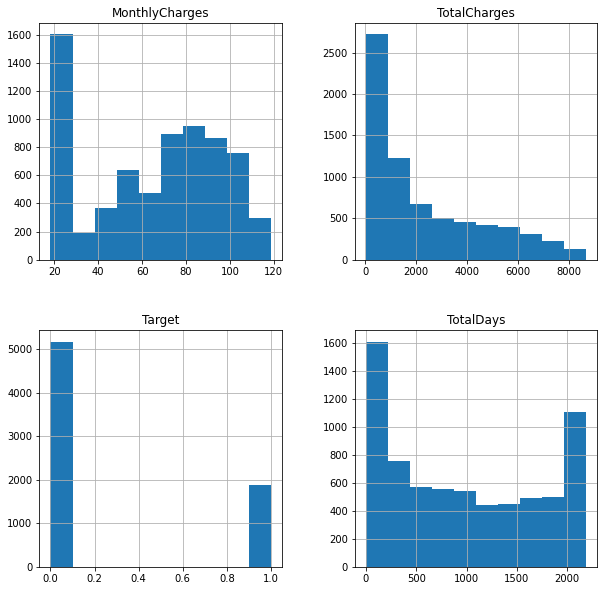

In [17]:
contact.hist(figsize = (10,10))

В целом распределения не особо равномерные. Существенный всплеск значений MonthlyCharges в районе 20у.е. может быть обусловлен самым дешевым (и потому популярным) тарифом. Посмотрим на него внимательней. Суммарные затраты похожи на экспоненциальное распределение, что похоже на правду, а вот TotalDays имеет очень странную структуру, со пиком околонулевых значений и в конце дальше 2000 дней. Посмотрим на него потом.

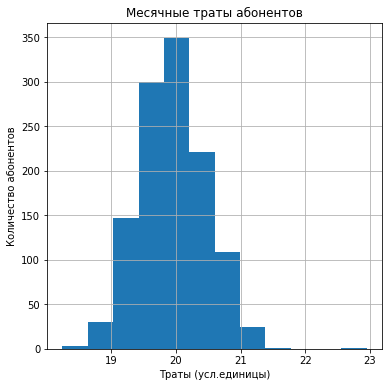

In [18]:
contact[contact['MonthlyCharges'] <= 23]['MonthlyCharges'].hist(bins = 12, figsize = (6,6))
plt.title("Месячные траты абонентов")
plt.xlabel("Траты (усл.единицы)")
plt.ylabel("Количество абонентов")
plt.show()

In [19]:
print(contact [contact['MonthlyCharges'] < 20.5 ]['MonthlyCharges'].value_counts(ascending = False).head(10))

display(contact [contact['MonthlyCharges'] == 20].head())

20.05    61
19.85    45
19.95    44
19.90    44
19.70    43
20.00    43
19.65    43
20.15    40
19.55    40
19.75    39
Name: MonthlyCharges, dtype: int64


,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Target,TotalDays
213,4709-LKHYG,2017-09-01,2020-02-01,One year,20.0,540.05,0,883
458,4237-CLSMM,2019-12-01,2020-02-01,Month-to-month,20.0,38.00,0,62
584,2393-DIVAI,2019-11-01,2020-02-01,Month-to-month,20.0,61.70,0,92
624,1009-IRMNA,2019-04-01,2019-11-01,Month-to-month,20.0,137.60,1,214
798,3807-XHCJH,2020-01-01,2020-02-01,Month-to-month,20.0,20.00,0,31


Похоже, что 20 у.е. это минимальный тариф, которое выбирает большинство абонентов. Поэтому всплекск есть, но его можно объяснить. Посмотрим сейчас на минимальный значения суммарных поступлений.

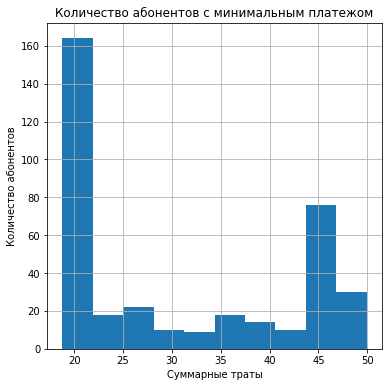

In [20]:
contact[contact['TotalCharges'] <= 50]['TotalCharges'].hist(bins = 10, figsize = (6,6))
plt.title("Количество абонентов с минимальным платежом")
plt.xlabel("Суммарные траты")
plt.ylabel("Количество абонентов")
plt.show()

In [21]:
contact[contact['TotalCharges'] <= 25]['TotalDays'].value_counts()

31    143
30     35
0       4
Name: TotalDays, dtype: int64

Люди, заплатившие до 25 у.е. пользуются услугами 1 месяц, это значит, что данные скорее верны, чем ошибочны. 

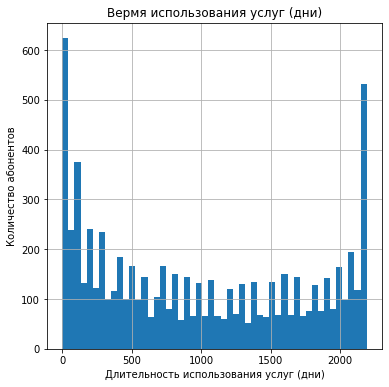

In [22]:
contact['TotalDays'].hist(bins = 50, figsize = (6,6))
plt.title("Вермя использования услуг (дни)")
plt.xlabel("Длительность использования услуг (дни)")
plt.ylabel("Количество абонентов")
plt.show()

Очень много новичков. Но и тех, кто пользуется услугами очень долго, тоже много. Получается, что надо либо оставлять середину от выборки, либо оставлять всё как есть, выбираю второй вариант. 

In [23]:
contact.describe()

,MonthlyCharges,TotalCharges,Target,TotalDays
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166
std,30.090047,2266.730170,0.441561,747.587844
min,18.250000,18.800000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000
50%,70.350000,1394.550000,0.000000,883.000000
75%,89.850000,3786.600000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


После обработки базы контактов данные выглядят так. Характерных вбросов нет,  максимальные и минимальные значения без аномалий. Можно переходить дальше.

### Персональные данные

In [24]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [25]:
personal.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


Количество записей в персональных данных совпадает с их количеством в договорах, поэтому я планирую их объединить. Но сперва посмотрим. какие данные нам нужны. Пол человека - наверное, важный показатель, как и возраст. А вот партнер или иждивенец - тут всё не так очевидно. Посмотрим на них внимательней.

In [26]:
personal['Partner'] = (personal['Partner'] == 'Yes') * 1
personal['Dependents'] = (personal['Dependents'] == 'Yes') * 1
personal['Female'] = (personal['gender'] == 'Female') * 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41acbd2610>,
      dtype=object)

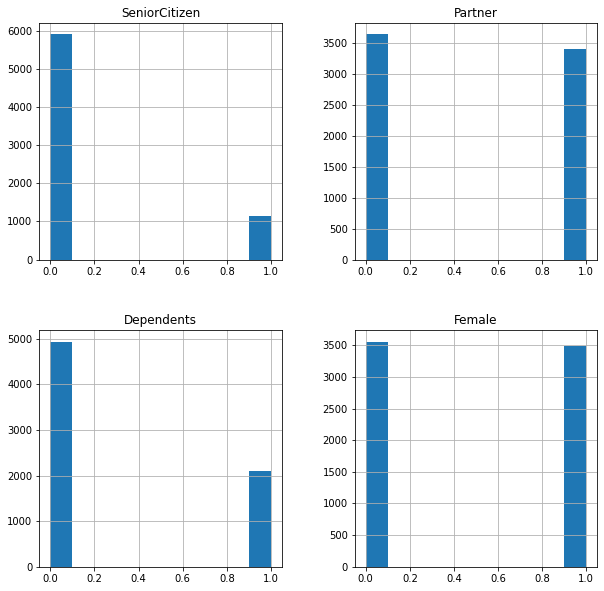

In [27]:
personal.hist(figsize=(10,10))

Корреляцию методом Спирмена-Пирсона не померить между категориальными переменными, поэтому надо либо все добавлять, либо все удалять. Я добавлю, будет обидно выкидывать признаки, которые могут оказаться полезными. При осмотре важности признаков их можно будет удалить.

In [28]:
personal =  personal.drop('gender', 1)
personal.head(3)

,customerID,SeniorCitizen,Partner,Dependents,Female
0,7590-VHVEG,0,1,0,1
1,5575-GNVDE,0,0,0,0
2,3668-QPYBK,0,0,0,0


Объединим таблицы personal и contact в общую, с которой будем потом работать.

In [29]:
df = contact.merge (personal, on = 'customerID', how = 'outer')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customerID      7043 non-null   object        
 1   BeginDate       7043 non-null   datetime64[ns]
 2   EndDate         7043 non-null   datetime64[ns]
 3   Type            7043 non-null   object        
 4   MonthlyCharges  7043 non-null   float64       
 5   TotalCharges    7043 non-null   float64       
 6   Target          7043 non-null   int64         
 7   TotalDays       7043 non-null   int64         
 8   SeniorCitizen   7043 non-null   int64         
 9   Partner         7043 non-null   int64         
 10  Dependents      7043 non-null   int64         
 11  Female          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 715.3+ KB


Объединение прошло успешно. Переходим далее.

### Телефон

In [31]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [32]:
phone['MultipleLines'] = (phone['MultipleLines'] == 'Yes') * 1

Тут только 1 параметр, но он не для всех пользователей. Видимо, те, кого тут нет, у них нет и телефона. Присоединим всех к уже существующей общей таблице. И добавим параметр Телефон, пропуски заменю на нули - нет телефона, нет мультилинии.

In [33]:
df = df.merge(phone, on = 'customerID', how = 'left')

In [34]:
df['Phone'] = (df['MultipleLines'].isna() == False) * 1
df['MultipleLines'] = df['MultipleLines'].fillna(0).astype('int')

In [35]:
df.head(2)
#df.info()

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen,Partner,Dependents,Female,MultipleLines,Phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,29.85,0,31,0,1,0,1,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,1889.50,0,1036,0,0,0,0,0,1


Новый признак появлися, объединение прошло успешно. Осталось разобраться с интернетом.

### Интернет

In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Тут ситуация аналогичная с телефоном. Заполнены не все кастомер ай-ди, значит у некоторых нет интренета (они пользуются только телеофном (надо будет проверить)), поэтому можно ввести еще один признак - Интренет. 

In [37]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Нет уверенности. что доп услуги оказывают влияние на уходящих пользователей. Но все равно пока их оставим, а позже оценим важность этих признаков на итоговые предсказания модели.

In [38]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [39]:
cat_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cat_columns:
  internet[col] = (internet[col] == 'Yes') * 1

In [40]:
df = df.merge( internet, on = 'customerID', how = 'left')

In [41]:
print ('Проверка на дорогах')
print ('Количество пропусков в графе Интернет: ', df['InternetService'].isna().sum())
print ('Количество телефонов в без интернета: ', df[df['InternetService'].isna() == True]['Phone'].sum())

Проверка на дорогах
Количество пропусков в графе Интернет:  1526
Количество телефонов в без интернета:  1526


Всё сходится. Люди не имеющие интернета, имеют телефон. Но нектороые имеют и то и другое, поэтому интернет и телефон не будут взаимно коллинеарны.

In [42]:
df['Internet'] = (df['InternetService'].isna() == False) * 1


Тут мы заменим получившиеся пропуски на нули. Они образовались, когда соединяли таблицы у тех, у кого был только телефон.

In [43]:
df['InternetService'] = df['InternetService'].fillna(0)
for cat in cat_columns:
  df[cat] = df[cat].fillna(0)
  df[cat] = df[cat].astype ('int')

### Итоговые данные

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7043 non-null   float64       
 6   Target            7043 non-null   int64         
 7   TotalDays         7043 non-null   int64         
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  Female            7043 non-null   int64         
 12  MultipleLines     7043 non-null   int64         
 13  Phone             7043 non-null   int64         
 14  InternetService   7043 n

In [45]:
df.head()

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen,Partner,Dependents,Female,MultipleLines,Phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,29.85,0,31,0,1,0,1,0,0,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,1889.50,0,1036,0,0,0,0,0,1,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,53.85,108.15,1,61,0,0,0,0,0,1,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1840.75,0,1371,0,0,0,0,0,0,DSL,1,0,1,1,0,0,1
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,70.70,151.65,1,61,0,0,0,1,0,1,Fiber optic,0,0,0,0,0,0,1


**Вывод**

Данные подготовлены для обучения моделей. 
Осталось 3 столбца с типом 'object' - это ай-ди, тип договора и тип интренета. Для работы модели дата начала договора и дата его конца не нужна, есть дублирующие признак - год открытия договора и суммарное время (месяцы) пользования услугами. Целевой признак - Target. По нему будем вести предсказания. 

## Создание и обучение моделей

### Подготовка данных

Проверим корреляцию, между числовыми признаками, чтобы удалить мультиколлинеарность (если корреляция между признаками будет выше 0,8).


In [46]:
df[['MonthlyCharges', 'TotalCharges', 'TotalDays']].corr()

,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.651182,0.247754
TotalCharges,0.651182,1.000000,0.826095
TotalDays,0.247754,0.826095,1.000000


Суммарные поступления и время использования договра коррелируются выше, чем 0,8, придется отазаться от одного из этих признаков. Откажемся от суммарных поступлений. Удалим все ненужные фичи при выделении признаком для обучения моделей.

In [47]:
features = df.drop(['customerID', 'BeginDate', 'EndDate', 'TotalCharges', 'Target'], axis = 1).copy()
target = df['Target'].copy()

Разобьем данные на обучающую и тестовую выборки в соотношениее 80-20%. Использовать валидационную не будем, т.к. большинство моделей работают с кросс-валидацией и сами сделают подвыборку из обучающей части для валидации. 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=2021)

print ('Размер обучающей выборки: ', len(X_train))

print ('Размер тестовой выборки: ',len(X_test))

Размер обучающей выборки:  5634
Размер тестовой выборки:  1409


### Catboost

Зайдем с козырей - обучим категориальный бустинг и посмотрим важность признаков для него, чтобы последнующие модели могли обучаться на меньшем количестве данных.

In [49]:
X_train.columns #для вывода категориальных переменных

Index(['Type', 'MonthlyCharges', 'TotalDays', 'SeniorCitizen', 'Partner',
       'Dependents', 'Female', 'MultipleLines', 'Phone', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Internet'],
      dtype='object')

In [50]:
cat_features =['Type', 'SeniorCitizen', 'Partner', 'Dependents', 'Female', 'MultipleLines',
       'Phone', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Internet']

cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

In [51]:
params = {'loss_function': 'CrossEntropy',
          'eval_metric': 'AUC', 
          "verbose": False,
          'iterations' : 3000,
          'depth' : 4}

In [52]:
scores = cv(cv_dataset,
            params,
            fold_count=3)

Training on fold [0/3]

bestTest = 0.910818733
bestIteration = 2999

Training on fold [1/3]

bestTest = 0.9238018317
bestIteration = 2965

Training on fold [2/3]

bestTest = 0.9264499025
bestIteration = 2769



ROC-AUC при CV: 0.92032


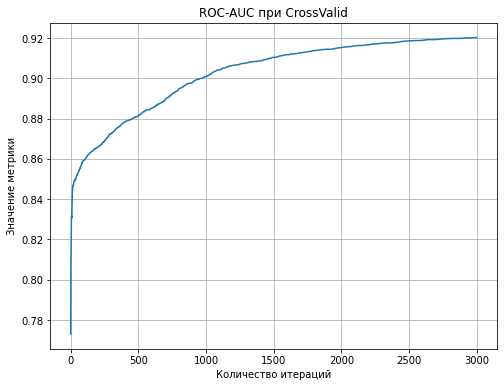

In [53]:
print ('ROC-AUC при CV: {:.5f}'.format(scores['test-AUC-mean'].max()))
scores['test-AUC-mean'].plot(grid = True, figsize = (8,6))
plt.title("ROC-AUC при CrossValid")
plt.xlabel("Количество итераций")
plt.ylabel("Значение метрики")
plt.show()

### Оценка влияния признаков на итоговое предсказание модели

Запустим Кэтбуст без настроек для определения важных фичей

In [54]:
cb = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC', depth = 4)
cb.fit(X_train, y_train, eval_set=(X_test,y_test), cat_features = cat_features)

print('Важность признаков для итогового предсказания:')

cat_range = pd.DataFrame (data = cb.get_feature_importance(), index = X_train.columns, columns = ['range'])
print (cat_range.sort_values(by = 'range',ascending  = False))

Важность признаков для итогового предсказания:
                      range
TotalDays         66.888316
MonthlyCharges    10.092498
Type               9.379457
InternetService    3.488468
Internet           2.576968
Phone              0.904237
TechSupport        0.855185
SeniorCitizen      0.806623
OnlineSecurity     0.761925
Female             0.757575
MultipleLines      0.713427
StreamingTV        0.658022
Partner            0.646487
StreamingMovies    0.583240
Dependents         0.402363
OnlineBackup       0.295873
DeviceProtection   0.189335


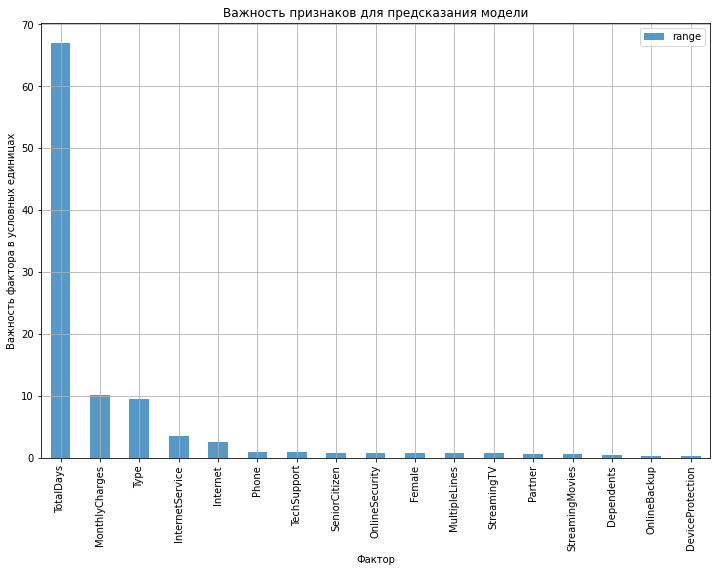

In [55]:
cat_range.sort_values(by = 'range',ascending  = False).plot(kind='bar', 
                                                            alpha = 0.75, legend = True, figsize = (12,8), grid = True)
plt.title("Важность признаков для предсказания модели")
plt.xlabel("Фактор")
plt.ylabel("Важность фактора в условных единицах")
plt.show()

Наибольшее влияение на модель оказывает время использования услуг. Что является очень подозрительным, как будто бы новые абоненты уходят чаще старых или наоборот. Разрберемся с этим позже. 
Оказывается, что не все введеные признаки оказались важны для работы модели. Например, наличие телефона практически не влияет на предсказание. А тип договора и ежемесячные траты, наоборот, оказались вторыми по важности признаками. 
Избавимся от наименее важных фич (FI < 2) и посмотрим на то, как изменится предсказание модели.

In [56]:
X_train_1 = X_train[['TotalDays', 'MonthlyCharges', 'Type',
                     'InternetService', 'Internet']].copy()

X_test_1 = X_test[['TotalDays', 'MonthlyCharges', 'Type',
                     'InternetService', 'Internet']].copy()

In [57]:
X_train_1.columns

Index(['TotalDays', 'MonthlyCharges', 'Type', 'InternetService', 'Internet'], dtype='object')

In [58]:
cat_features_1 = ['Type', 'InternetService', 'Internet']

Training on fold [0/3]

bestTest = 0.9114673078
bestIteration = 2971

Training on fold [1/3]

bestTest = 0.9339516477
bestIteration = 2996

Training on fold [2/3]

bestTest = 0.9313646589
bestIteration = 2984

ROC-AUC при CV: 0.92556


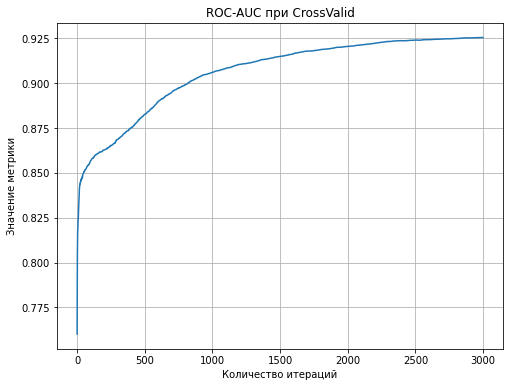

In [59]:
cv_dataset_1 = Pool(data=X_train_1,
                  label=y_train,
                  cat_features=cat_features_1)

scores_1 = cv(cv_dataset_1,
            params,
            fold_count=3)

print ('ROC-AUC при CV: {:.5f}'.format(scores_1['test-AUC-mean'].max()))
scores_1['test-AUC-mean'].plot(grid = True, figsize = (8,6))
plt.title("ROC-AUC при CrossValid")
plt.xlabel("Количество итераций")
plt.ylabel("Значение метрики")
plt.show()

In [60]:
cb_1 = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC')

cb_1.fit(X_train_1, y_train, eval_set=(X_test_1,y_test), cat_features = cat_features_1)

cat_roc = cb_1.best_score_['validation']['AUC']
cat_acc = accuracy_score(y_test, cb_1.predict(X_test_1))
print('AUC valid: {:.5f}'.format(cat_roc))
print('Accuracy test: {:.5f}'.format(cat_acc))

AUC valid: 0.92838
Accuracy test: 0.87083


Убрав фичи с важностью меньше 2, мы получили небольшой прирост метрики на 2%.Это очень неплохой результат! Можно посмотреть теперь на менее сложные модели, такие как Логистическая регрессия, дерево решений и случайный лес.

### Подготовка выборок для простых моделей

Для работы с более простыми моделями проведем дамми-кодирование признаков. Масштабирование будет использовать то, которое уже вложено в модель. Будем использовать только те признаки, которые остались после работы фичерс-импортант.

In [61]:
#создание dummy-признаков
X_train_dum = pd.get_dummies(X_train_1, drop_first=True)
X_test_dum = pd.get_dummies(X_test_1, drop_first=True)

In [62]:
display(X_train_dum.head(2))
print(X_train_dum.shape)

,TotalDays,MonthlyCharges,Internet,Type_One year,Type_Two year,InternetService_DSL,InternetService_Fiber optic
6125,395,102.25,1,0,0,0,1
6958,396,19.75,0,0,1,0,0


(5634, 7)


### Логистическая регрессия

In [63]:
model_log = LogisticRegression(class_weight = 'balanced', solver = 'saga')

model_log.fit(X_train_dum, y_train)

proba_log_test = model_log.predict_proba(X_test_dum)
proba_log_1_test = proba_log_test[:, 1]

log_roc = roc_auc_score(y_test, proba_log_1_test)
log_acc = accuracy_score (y_test, model_log.predict(X_test_dum))  

print('LogisticRegression. Test ROC_AUC: {:.5f}'.format(log_roc))
print('LogisticRegression. Test Accuracy: {:.5f}'.format(log_acc))

LogisticRegression. Test ROC_AUC: 0.81063
LogisticRegression. Test Accuracy: 0.68701


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### DecisionTree

In [64]:
model_tree = DecisionTreeClassifier(random_state = 2021, class_weight='balanced')

param_grid_tree = {
    'max_depth' : [3,4,5,6,7,8],
    'min_samples_leaf' : [10,20,40,60,80,100,120,140,160,180,200],
    'max_leaf_nodes' : [6,8,10,12,14,16]
}

grid_tree = GridSearchCV(estimator = model_tree, param_grid = param_grid_tree, 
                         scoring = 'roc_auc', 
                         error_score='raise', cv=3
                         )
grid_tree.fit(X_train_dum, y_train)

print('Гиперпараметры модели:', grid_tree.best_params_)

proba_tree_test = grid_tree.predict_proba(X_test_dum)
proba_tree_1_test = proba_tree_test[:, 1]

tree_roc = roc_auc_score(y_test, proba_tree_1_test) 
tree_acc = accuracy_score (y_test, grid_tree.predict(X_test_dum))    

print('Tree. Test ROC_AUC: {:.5f}'.format(tree_roc))
print('Tree. Test Accuracy: {:.5f}'.format(tree_acc))

Гиперпараметры модели: {'max_depth': 8, 'max_leaf_nodes': 16, 'min_samples_leaf': 10}
Tree. Test ROC_AUC: 0.84377
Tree. Test Accuracy: 0.71469


### RandomForest

In [65]:
model_forest = RandomForestClassifier(random_state = 2021, class_weight='balanced')

param_grid_forest = {
    'max_depth' : [4, 6, 12, 24, 48, 96],
    'n_estimators': [60, 100, 150],
    'min_samples_leaf' : [4, 6, 8, 10, 12]
}

grid_forest = GridSearchCV(estimator = model_forest, param_grid = param_grid_forest, 
                         scoring = 'roc_auc', 
                         error_score='raise', cv = 3)

grid_forest.fit(X_train_dum, y_train)


print('Гиперпараметры модели:', grid_forest.best_params_)

proba_forest_test = grid_forest.predict_proba(X_test_dum)
proba_forest_1_test = proba_forest_test[:, 1]

forest_roc = roc_auc_score(y_test, proba_forest_1_test)
forest_acc = accuracy_score (y_test, grid_forest.predict(X_test_dum))   

print('Forest. Test ROC_AUC: {:.5f}'.format(forest_roc))
print('Forest. Test Accuracy: {:.5f}'.format(forest_acc))

Гиперпараметры модели: {'max_depth': 12, 'min_samples_leaf': 4, 'n_estimators': 150}
Forest. Test ROC_AUC: 0.85747
Forest. Test Accuracy: 0.77218


### GradientBoosting

In [66]:
model_clf = GradientBoostingClassifier (random_state = 2021)

param_grid_clf = {
    'max_depth' : [2, 3,4],
    'n_estimators': [20, 40, 60, 80],
    'min_samples_leaf' : [4, 6, 8, 10],
    'learning_rate' : [0.1, 1]
}

grid_clf = GridSearchCV(estimator = model_clf, param_grid = param_grid_clf, 
                         scoring = 'roc_auc', 
                         error_score='raise', cv = 3)

grid_clf.fit(X_train_dum, y_train)


print('Гиперпараметры модели:', grid_clf.best_params_)

proba_clf_test = grid_clf.predict_proba(X_test_dum)
proba_clf_1_test = proba_clf_test[:, 1]

clf_roc = roc_auc_score(y_test, proba_clf_1_test)   
clf_acc = accuracy_score (y_test, grid_clf.predict(X_test_dum))

print('GBC. Test ROC_AUC: {:.5f}'.format(clf_roc))
print('GBC. Test Accuracy: {:.5f}'.format(clf_acc))

Гиперпараметры модели: {'learning_rate': 1, 'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 80}
GBC. Test ROC_AUC: 0.91684
GBC. Test Accuracy: 0.87083


### Neural network

Для работы нейронной сети, надо опять подготовить данные.

In [67]:
X = X_train_dum.values
Y = y_train.values

In [68]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Трехслойная нейронная сеть показала себя весьма неплохо, а увеличение нейронов практически не улучшало резльтат. Поэтому для имеющихся данных сеть большая, но в общем смысле - маленькая.

In [69]:
# создание модели нейронной сети
def create_baseline():
  opti_adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
  model = Sequential()
  model.add(Dense(12, input_dim=7, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opti_adam, 
                metrics=[tf.keras.metrics.AUC()])  
  return model

#расчет при выделении 10% в тестовую выборку
estimator = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results_roc = cross_validate(estimator, X, encoded_Y, cv=kfold,
                         scoring='roc_auc')

results_acc = cross_validate(estimator, X, encoded_Y, cv=kfold,
                         scoring='accuracy')

keras_roc = results_roc['test_score'].max()
keras_acc = results_acc['test_score'].max()

print('Среднее значение ROC_AUC {:.5f}'.format(results_roc['test_score'].mean()))
print('Наибольшее значение ROC_AUC {:.5f}'.format(keras_roc))
print('Наибольшее значение Accuracy {:.5f}'.format(keras_acc))

Среднее значение ROC_AUC 0.79166
Наибольшее значение ROC_AUC 0.86075
Наибольшее значение Accuracy 0.82624


## Результат работы моделей

Подведем результаты работы моделей в одном месте, снабдив их графическим представлением. Сравнения с константной моделью не будет, т.к. при ней рок-аук будет 0,5. 

In [70]:
summary = pd.DataFrame (index = ['Catboost', 'LogRegression', 'Tree', 'Forest',
                                 'GradientBoosting', 'KerasClassifier'],
                        data = {'ROC-AUC': [cat_roc, log_roc, tree_roc, 
                                forest_roc, clf_roc, keras_roc], 
                                'Accuracy': [cat_acc, log_acc, tree_acc, 
                                forest_acc, clf_acc, keras_acc]})

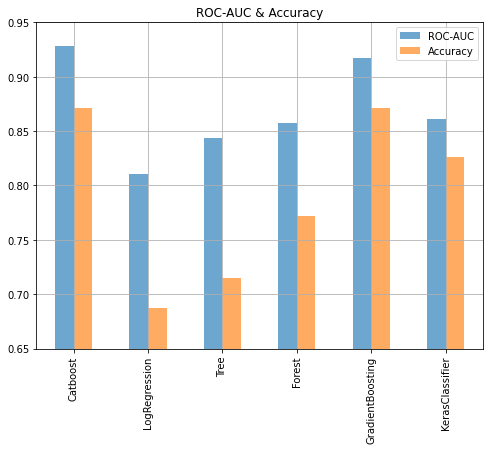

In [71]:
summary.plot(grid = True, figsize = (8,6), title = 'ROC-AUC & Accuracy', kind = 'bar', 
             ylim = (0.65,0.95), alpha = 0.65, legend = True)

**Вывод**

При таком наборе данных, отметку в 0,9 ROC_AUC преодолевает категориальный и градиентный бустинги, потом идет случайный лес. Нейронная сеть себя показала не самым лучшим образом, наверное, поэтому ее обычно не используют для работы с табличными данными.

Таким образом победа достается catboost. С долей правильных ответов (accuracy) в районе 87% можно быть уверенным, что наша телеком компания не обанкроитится. 

Значение метрик для лучшей модели:

In [74]:
print('Accuracy: ', round(cat_acc, 5))
print('Presicion: ', round(precision_score(y_test, cb_1.predict(X_test_1)), 5))
print('Recall: ', round(recall_score(y_test, cb_1.predict(X_test_1)), 5))
print('AUC-ROC: ', round(cat_roc, 5))

Accuracy:  0.87083
Presicion:  0.84459
Recall:  0.64767
AUC-ROC:  0.92838


## Вывод по работе моделей

В результате работы была выбрана модель, дающая наибольшее значение целевой метрики, и максимальное значение точности предсказаний (для интерпретации выводов). Были проанализированы исходные данные и оптимизированы шесть моделей классификации, из которых лучшей оказался catboost со значением ROC-AUC = 0.9284.

Кривая целевое метрики ROC-AUC

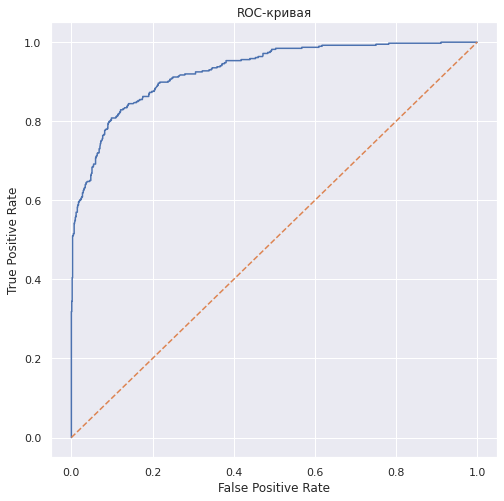

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, cb_1.predict_proba(X_test_1)[:,1])

sns.set()
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

### Описание портрета уходящего клиента

Признаки, оказывающие наибольшее влияние на расторжение договора абонентом

In [76]:
cat_range_report = pd.DataFrame (data = cb_1.get_feature_importance(), index = X_train_1.columns, columns = ['range'])
print (cat_range_report.sort_values(by = 'range',ascending  = False))

                     range
TotalDays        70.688350
MonthlyCharges   13.360075
Type              8.877999
InternetService   4.853744
Internet          2.219833


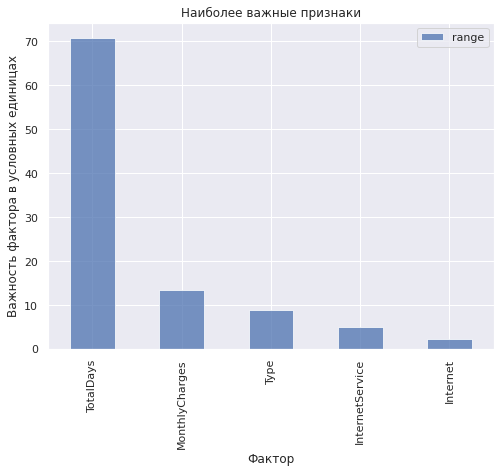

In [77]:
cat_range_report.sort_values(by = 'range',ascending  = False).plot(kind='bar', 
                                                            alpha = 0.75, legend = True, figsize = (8,6), grid = True)
plt.title("Наиболее важные признаки")
plt.xlabel("Фактор")
plt.ylabel("Важность фактора в условных единицах")
plt.show()

Описание клиента на основе предсказаний модели

In [78]:
df_report = X_test_1.join(y_test)

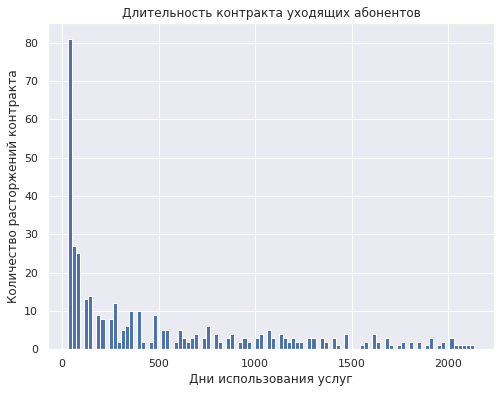

In [79]:
df_report[df_report['Target'] == 1]['TotalDays'].plot(kind = 'hist', bins = 100, 
                                                      figsize = (8,6))
plt.xlabel('Дни использования услуг')
plt.ylabel('Количество расторжений контракта')
plt.title('Длительность контракта уходящих абонентов')
plt.show()

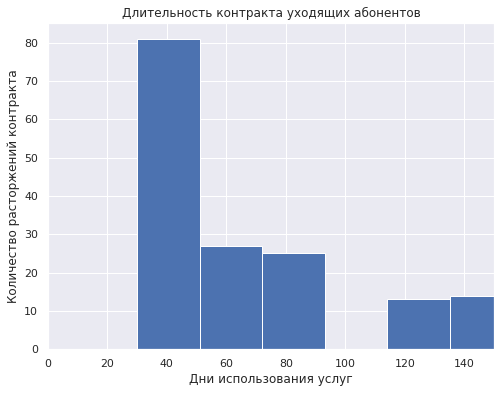

In [80]:
df_report[df_report['Target'] == 1]['TotalDays'].plot(kind = 'hist', 
                          xlim= (0,150), bins = 100, figsize = (8,6))
plt.xlabel('Дни использования услуг')
plt.ylabel('Количество расторжений контракта')
plt.title('Длительность контракта уходящих абонентов')
plt.show()

Необходимо обратить внимание на новых абонентов, длительность контрата которых менее 2 месяцев. Именно из этой группы уходит наибольшее количество людей.

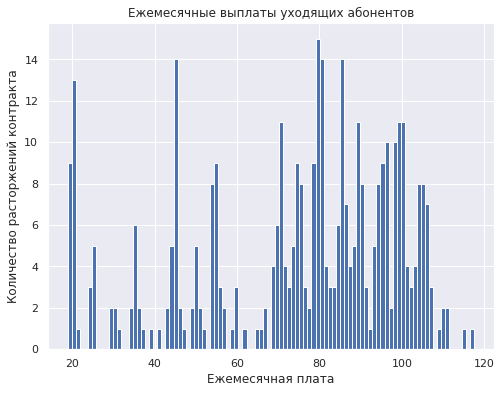

In [81]:
df_report[df_report['Target'] == 1]['MonthlyCharges'].plot(kind = 'hist', bins = 100, 
                                                      figsize = (8,6))
plt.xlabel('Ежемесячная плата')
plt.ylabel('Количество расторжений контракта')
plt.title('Ежемесячные выплаты уходящих абонентов')
plt.show()

Наибольшее число уходящих абонентов платят от 70 до 110 условных единиц в месяц. Можно рассмотреть для них возможность скидки или перевода на более дешевый тариф. 

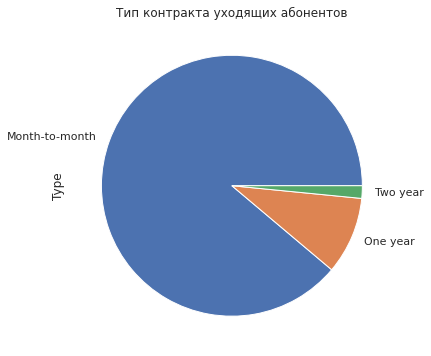

In [82]:
df_report[df_report['Target'] == 1]['Type'].value_counts().plot(
    kind = 'pie', figsize = (8,6))
plt.title('Тип контракта уходящих абонентов')
plt.show()

Данная круговая диаграмма показывает, что наибольшее количество уходящих абонентов имеют тип помесячной оплаты. Что подтврерждается наибольшим количеством расторжений в первые три месяца после заключения договора.

### Вывод

Наибольшее количество расторжений контрактов происходит среди абонентов с помесячной оплатой в первые три месяца после заключения договора, стоимость услгуг которых в среднем находится в интревале от 70 до 110 условных единиц. 

Разработанная модель правильно предсказывает вероятность ухода абонента в 87% случаев. Модель ошибочно маркирует как потенциально уходящих абонентов тех, которые не собираются уходить в 16% случаев. 